## Learning to Use [ImageGenerator](https://keras.io/preprocessing/image/)

Moving on from using MNIST Fashion Data-set we will use more realistic images of horses and humans ans try to classify them using CNN. Here We will learn to exploit the fantastic ImageGenerator class of Keras library. 
Images of horses and humans are divided in folders and they are not labeled. Keras will take care of that from the name of the folders where they are placed. Let's see how easy it is to train a deep neural network to train with Keras.   

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os

In [2]:
horse_train_im_path = os.path.join('./Images/horse-or-human/horses')
human_train_im_path = os.path.join('./Images/horse-or-human/humans')


horse_images = os.listdir(horse_train_im_path)
human_images = os.listdir(human_train_im_path)


print ("total number of horse images:", len(os.listdir(horse_train_im_path)))
print ("total number of human images:", len(os.listdir(human_train_im_path)))

total number of horse images: 500
total number of human images: 527


#### View few images using Matplotlib

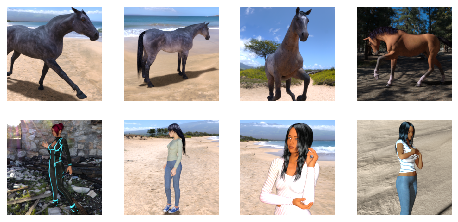

In [3]:
n_rows = 4
n_cols = 4
pic_index = 0 

fig = plt.gcf()
fig.set_size_inches(n_cols * 2, n_rows * 2)

pic_index += 8
next_horse_pix = [os.path.join(horse_train_im_path, fname) 
                for fname in horse_images[pic_index-4:pic_index]]
next_human_pix = [os.path.join(human_train_im_path, fname) 
                for fname in human_images[pic_index-4:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(n_rows, n_cols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

#### Dealing with Colored Images 

Compared to the grayscale images we have used for MNIST fashion data-set, now these images have 3 channels and also they are larger. We can specify the input shape of the images and all the images here are of shape (300, 300, 3). so we will perform comvolution over the full scale, but to reduce time one can try to reduce the input shape.   

In [4]:
import cv2
example_horse_im = cv2.imread('./Images/horse-or-human/horses/horse05-6.png')
print (type(example_horse_im))
print ("example image shape: ", example_horse_im.shape)

<class 'numpy.ndarray'>
example image shape:  (300, 300, 3)


### Buiding up the Convnet Model Step by Step Using keras

One major difference in the last layer compared to the MNIST fashion data is we are using a softmax classifier and treating this problem as binary classification problem. So output will be a number between 0 and 1 signifying probability of the image being classified as either human or horses. Different from multi-class problem! You can read about the loss function [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/) 

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)), 
    tf.keras.layers.MaxPooling2D(2, 2), 
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2), 
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2, 2), 
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    
])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 71, 71, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 33, 33, 64)       

let us understand the shape and parameters! 

* First layer is a conv layer with filter size (3, 3), thus the output shape is $(w-f+1, h-f+1, n_f)$, where $w, h, n_f$ are width, heights, and number of filters. 

* Number of Parameters: Input image size (300, 300, 3), number of filters 16, with size (3, 3). so total number of weights $f\times f\times n_f \times n_c = 3 \times 3 \times 16 \times 3 = 432$. Number of bias parameters = number of filters = 16. Thus total number of filters 432 + 16 = 448. 

* Maxpooling reduces the dimension to half. 

and it goes on...

We compile our model as below.. I will use Adam optimizer but you can check and play around with the choice of optimizer and learning rate parametrer. For more on optimizer you can read [here](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)

In [6]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='binary_crossentropy', 
             optimizer=Adam(lr=0.001), 
             metrics=['acc'])

### Data Processing with ImageGenerator

The datagenerator will read image files from folders, convert them to tensors (format of data will be float), and directly feed them to our network. We can specify the batch size, but before this we will normalize the pixel values to lie between 0 to 255. I am using _'flow_from_directory'_ method to take the images from the directories.  After using this method we will see the number of total images and number of classes (depending on the number of folders). 

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory('./Images/horse-or-human/', 
                                                   target_size=(300, 300), 
                                                   batch_size=64, 
                                                   class_mode='binary')

Found 1027 images belonging to 2 classes.


In [9]:
history = model.fit_generator(train_generator, 
                             steps_per_epoch=8, 
                             epochs=10,
                             verbose = 1)

Epoch 1/10
8/8 [==============================] - 21s 3s/step - loss: 0.7845 - acc: 0.5840
Epoch 2/10
8/8 [==============================] - 18s 2s/step - loss: 0.4172 - acc: 0.8847
Epoch 3/10
8/8 [==============================] - 21s 3s/step - loss: 0.1613 - acc: 0.9355
Epoch 4/10
8/8 [==============================] - 18s 2s/step - loss: 0.1161 - acc: 0.9534
Epoch 5/10
8/8 [==============================] - 19s 2s/step - loss: 0.1288 - acc: 0.9557
Epoch 6/10
8/8 [==============================] - 20s 3s/step - loss: 0.1186 - acc: 0.9512
Epoch 7/10
8/8 [==============================] - 21s 3s/step - loss: 0.0915 - acc: 0.9609
Epoch 8/10
8/8 [==============================] - 18s 2s/step - loss: 0.0632 - acc: 0.9756
Epoch 9/10
8/8 [==============================] - 21s 3s/step - loss: 0.0249 - acc: 0.9902
Epoch 10/10
8/8 [==============================] - 18s 2s/step - loss: 0.0462 - acc: 0.9867


#### Visualizing the Effect of Convolution 

To understand how the convolution filters look for features, we first need to understand the keras layers. We will take an image and see its journey through the layers. So we will first check some understanding and then slowly build up the procedure to extract info from different layers. As we see below _model.layers_ gives us the list of layers in terms of tensorflow conv, maxpool or dense objects. Output of all layers can be obtained using a simple one line command _layer.output for layer in model.layers_.  

We want to define a new model where our inputs are images obtained from model.input and output will be layer.output. If you print _model.input_, you will see it as a tensor of shape (None, 300, 300, 3). This makes sense because our images are of shape (300, 300, 3) and, the batch sizes are mentioned later. So if we take  a single image then it needs to be reshaped as (1, 300, 300, 3). Also we want to see the output of conv layers and max poopling layers, and not the dense layers. To ensure that we can select layer outputs only when the length of shape is equal to 4.         

Remaining tasks then are just to make some adjustments to create a grid and visualize output of every filter on each layer. So let's begin! I have made it simpler by plotting only the conv layers' outputs.   

In [10]:
print ("what is model.layers: ", model.layers)
print ("\n")
print ("what is model.input: ", model.input)

what is model.layers:  [<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9217e283c8>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9208596e48>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f92085b60b8>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f92085b6518>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f92085b6748>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f92085b6ba8>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f92085b6dd8>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f92085be278>, <tensorflow.python.keras.layers.core.Flatten object at 0x7f92085be4a8>, <tensorflow.python.keras.layers.core.Dense object at 0x7f92085be5f8>, <tensorflow.python.keras.layers.core.Dense object at 0x7f92085be908>]


what is model.input:  Tensor("conv2d_input:0", shape=(None, 300, 300, 3), dtype=float32)


number of features:  16
sizes:  149
number of features:  32
sizes:  147
number of features:  32
sizes:  73
number of features:  32
sizes:  71
number of features:  32
sizes:  35
number of features:  64
sizes:  33
number of features:  64
sizes:  16


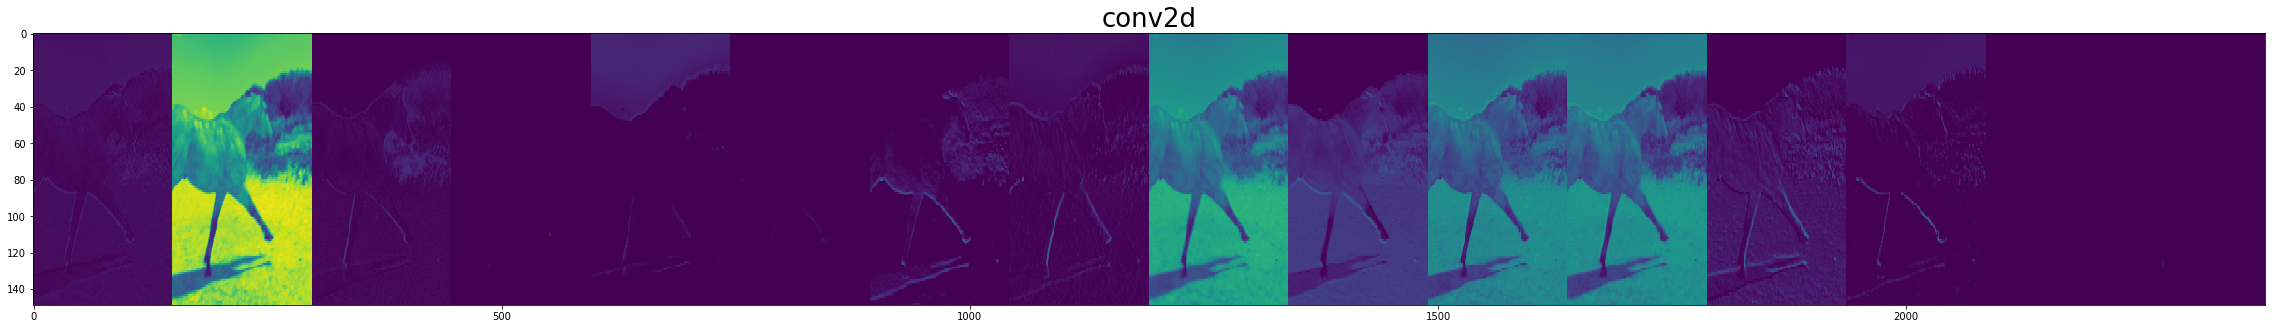

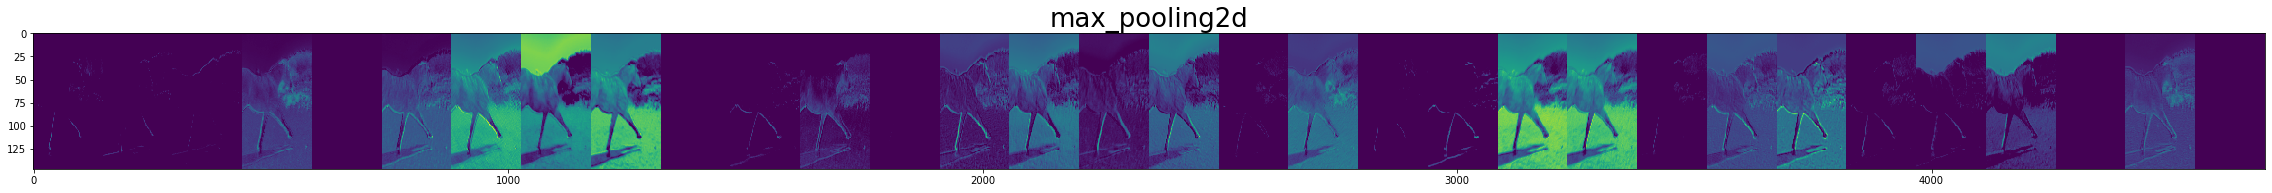

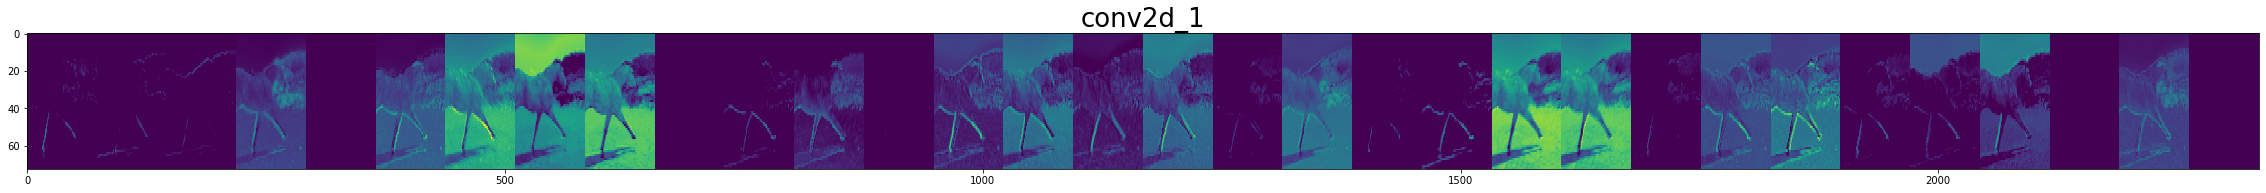

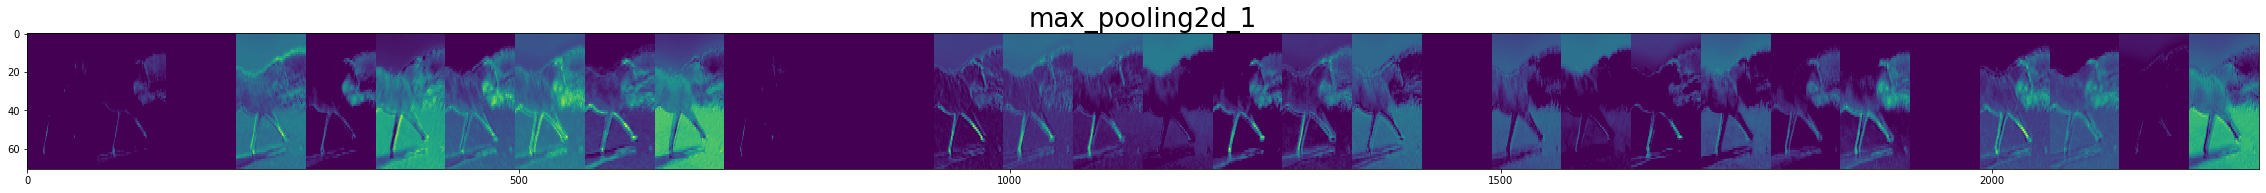

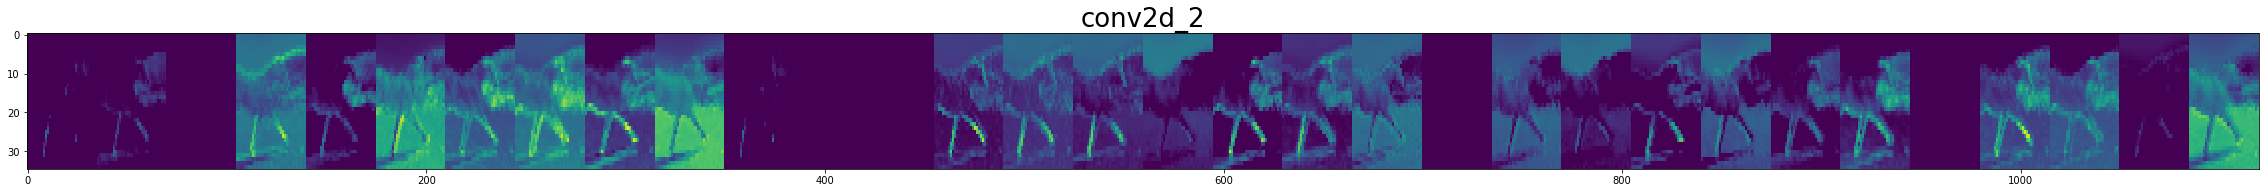

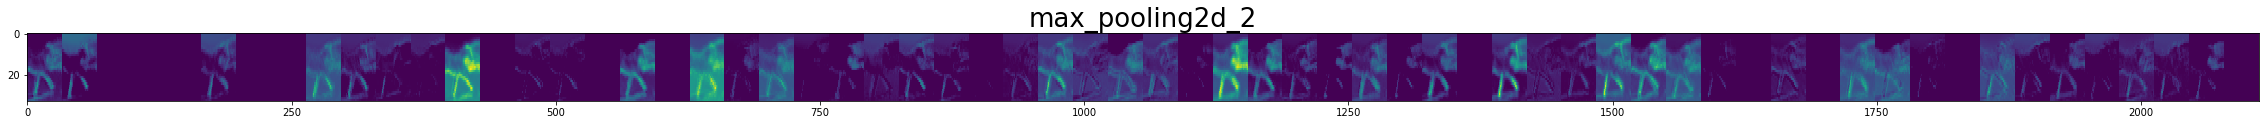

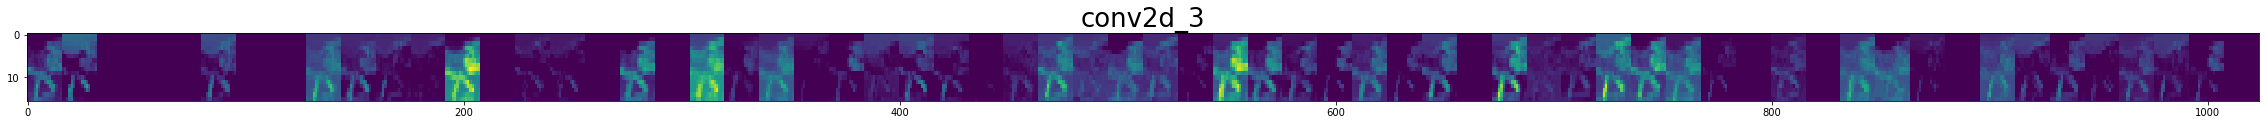

In [11]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random 


all_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = all_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(horse_train_im_path, f) for f in horse_images]
human_img_files = [os.path.join(human_train_im_path, f) for f in human_images]
img_path = random.choice(horse_img_files + human_img_files)

random_image = cv2.imread(img_path)
reshaped_random_image = np.reshape(random_image, (1, 300, 300, 3))

x_norm = reshaped_random_image/255.

respective_feature_maps = visualization_model.predict(x_norm)

# Include the names of the layers in the plot
layer_names = [layer.name for layer in model.layers]


# print ("layer names: ", layer_names)



for lyr_name, feature_map in zip(layer_names, respective_feature_maps):
    if len(feature_map.shape) == 4 and lyr_name!='max_pooling2d_4' and lyr_name!='max_pooling2d_5' and lyr_name!='max_pooling2d_6':
    # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of filters essentially
        # The feature map has shape (1, size, size, n_features)
        print ("number of features: ", n_features)
        size = feature_map.shape[1] # reduced height of the image, 
        print ("sizes: ", size)
        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features)) # 2d array of shape: reduced image height, height*filters
        for i in range(n_features):
      # Postprocess the feature to make it visually palatable
            x_norm = feature_map[0, :, :, i]
#             x -= x.mean()
#             x /= x.std()
#             x *= 64
#             x += 128
#             x = np.clip(x, 0, 128).astype('uint8')
      # We'll tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x_norm
    # Display the grid
        scale = 40. / n_features
        plt.figure(figsize=(scale * n_features, scale*2))
        plt.title(lyr_name, fontsize=26)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

If we want to test our model, we can add a validation data-set. In that case we can have a validation datagenerator as below-- One point though is to use a batch size little lower than training data is usally used.  For this our fit generator will change too---  

In [51]:
# validation_generator = validation_datagen.flow_from_directory(
#         './Images/validation-horse-or-human/',
#         target_size=(300, 300), 
#         batch_size=32, 
#         class_mode='binary')


# history = model.fit_generator(
#       train_generator,
#       steps_per_epoch=8,  
#       epochs=10,
#       verbose=1,
#       validation_data = validation_generator,
#       validation_steps=8)

#### A little more (simplified version of the previous one) Visualization 

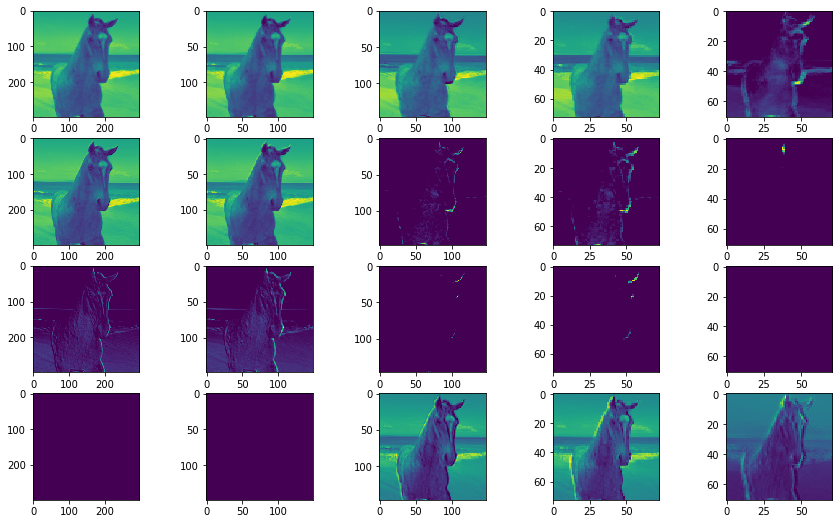

In [28]:
fig, axs = plt.subplots(4, 5, figsize=(15, 9))

horse_im = cv2.imread('./Images/horse-or-human/horses/horse20-3.png')

horse_im_rescale = horse_im 
human_im_rescale = human_im

 


CONVOLUTION_NUMBER = 8
CONVOLUTION_NUMBER1 = 10
CONVOLUTION_NUMBER2 = 12
CONVOLUTION_NUMBER3 = 14
 
from tensorflow.keras import models
all_layer_outputs = [layer.output for layer in model.layers] # Now we include all the layers
activation_model = tf.keras.models.Model(inputs = model.input, outputs=all_layer_outputs)

for x in range(0, 5):
    f1 = activation_model.predict(horse_im_rescale.reshape(1, 300, 300, 3))[x]
    axs[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
    axs[0,x].grid(False)
    f2 = activation_model.predict(horse_im_rescale.reshape(1, 300, 300, 3))[x]
    axs[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER1], cmap='viridis')
    axs[1,x].grid(False)
    f3 = activation_model.predict(horse_im_rescale.reshape(1, 300, 300, 3))[x]
    axs[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER2], cmap='viridis')
    axs[2,x].grid(False)
    f4 = activation_model.predict(horse_im_rescale.reshape(1, 300, 300, 3))[x]
    axs[3,x].imshow(f4[0, : , :, CONVOLUTION_NUMBER3], cmap='viridis')
    axs[3,x].grid(False)

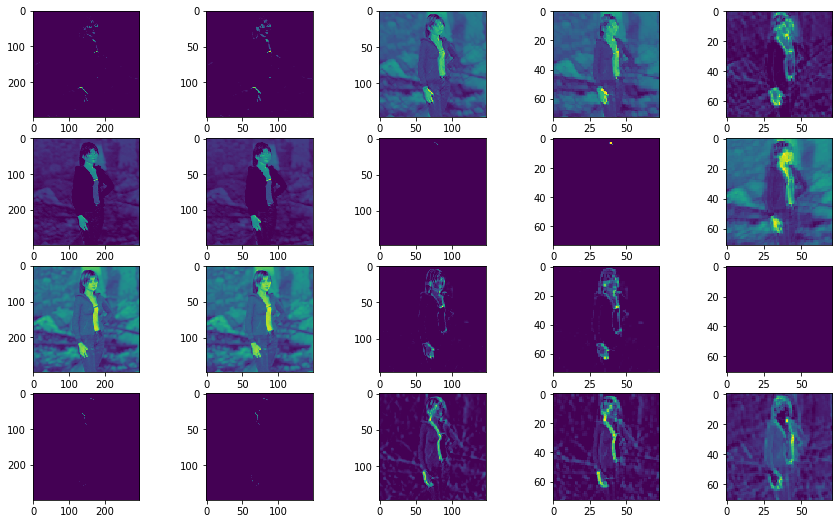

In [31]:
fig, axs = plt.subplots(4, 5, figsize=(15, 9))

human_im = cv2.imread('./Images/horse-or-human/humans/human03-20.png')


human_im_rescale = human_im

 


CONVOLUTION_NUMBER = 6
CONVOLUTION_NUMBER1 = 9
CONVOLUTION_NUMBER2 = 11
CONVOLUTION_NUMBER3 = 15
 
from tensorflow.keras import models
all_layer_outputs = [layer.output for layer in model.layers] # Now we include all the layers
activation_model = tf.keras.models.Model(inputs = model.input, outputs=all_layer_outputs)

for x in range(0, 5):
    f1 = activation_model.predict(human_im_rescale.reshape(1, 300, 300, 3))[x]
    axs[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')
    axs[0,x].grid(False)
    f2 = activation_model.predict(human_im_rescale.reshape(1, 300, 300, 3))[x]
    axs[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER1], cmap='viridis')
    axs[1,x].grid(False)
    f3 = activation_model.predict(human_im_rescale.reshape(1, 300, 300, 3))[x]
    axs[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER2], cmap='viridis')
    axs[2,x].grid(False)
    f4 = activation_model.predict(human_im_rescale.reshape(1, 300, 300, 3))[x]
    axs[3,x].imshow(f4[0, : , :, CONVOLUTION_NUMBER3], cmap='viridis')
    axs[3,x].grid(False)